In [1]:
%%time
# Imports
from utils import *

CPU times: total: 1.47 s
Wall time: 7.08 s


File-Reading

In [4]:
%%time

# Get start time
start = time.perf_counter()

# File-Reading
path = os.path.join(os.getcwd() , out_file) # from utils
# user = []
ts = []
# ca = []
tweets = []
# mentions = []
# coord = []
country = []

with open(path , 'r' , encoding='utf-8') as in_file:
    csv_reader = csv.reader(in_file , delimiter = "|")
    for line in csv_reader:
        # user.append(line[0])
        ts.append(line[1])
        # ca.append(line[2])
        tweets.append(line[3])
        # mentions.append(line[4])
        # coord.append(line[5])
        country.append(line[6])

ts_convert = [datetime.datetime.fromtimestamp(int(dt)//1000) for dt in ts]

CPU times: total: 34.7 s
Wall time: 35.7 s


### **QUESTION 1**

Identify 3 days with unusually high activity in 3 different countries of your choosing. For example you could choose one day in the UK, one in France and one in Turkey. Describe and justify how you identify ‘unusual’ days.

In [10]:
twt_df = pd.DataFrame(
    list(zip(tweets , ts_convert , country)),
    columns = ['tweet_id' , 'ts' , 'country']
)

twt_df = twt_df[twt_df['tweet_id']!="None"].drop_duplicates()

In [80]:
# https://www.kaggle.com/datasets/prasertk/country-name-in-different-languages
country_codes = pd.read_csv(
    os.path.join(
        os.getcwd() , 'country name in different languages.csv'
        )
    )

# Let's randomly decide on 3 countries for now.
country_list = ['United Kingdom' , 'France' , 'Turkey']

# Let's get these countries and the different names they're called by!
restricted_country_names = country_codes[country_codes['en'].isin(country_list)].drop('country_code' , axis = 1)
pivoted_country_names = pd.melt(
    restricted_country_names, id_vars=['en'], var_name='language', value_name='name'
    )[['en' , 'name']].drop_duplicates()

# English names are being left out - add them back in
english_names = []
for c in country_list:
    english_names.append([c , c])

english_name_df = pd.DataFrame(english_names , columns = ['en' , 'name'])
pivoted_country_names = pd.concat([pivoted_country_names , english_name_df] , axis = 0).drop_duplicates()

In [83]:
restricted_country_df = twt_df.merge(pivoted_country_names , left_on = 'country' , right_on = 'name' , how = 'inner')
restricted_country_df = restricted_country_df[['tweet_id' , 'ts' , 'en']]#.dropna()

# Create a date column
restricted_country_df['ts_day'] = pd.to_datetime(restricted_country_df['ts']).dt.date
# restricted_country_df.count()

# Group at day level
res_country_grp = restricted_country_df.groupby(['ts_day','en']).agg(num_twt = ('tweet_id' , 'nunique')).reset_index().set_index('ts_day')

tweet_id    7180790
ts          7180790
en          7180790
ts_day      7180790
dtype: int64

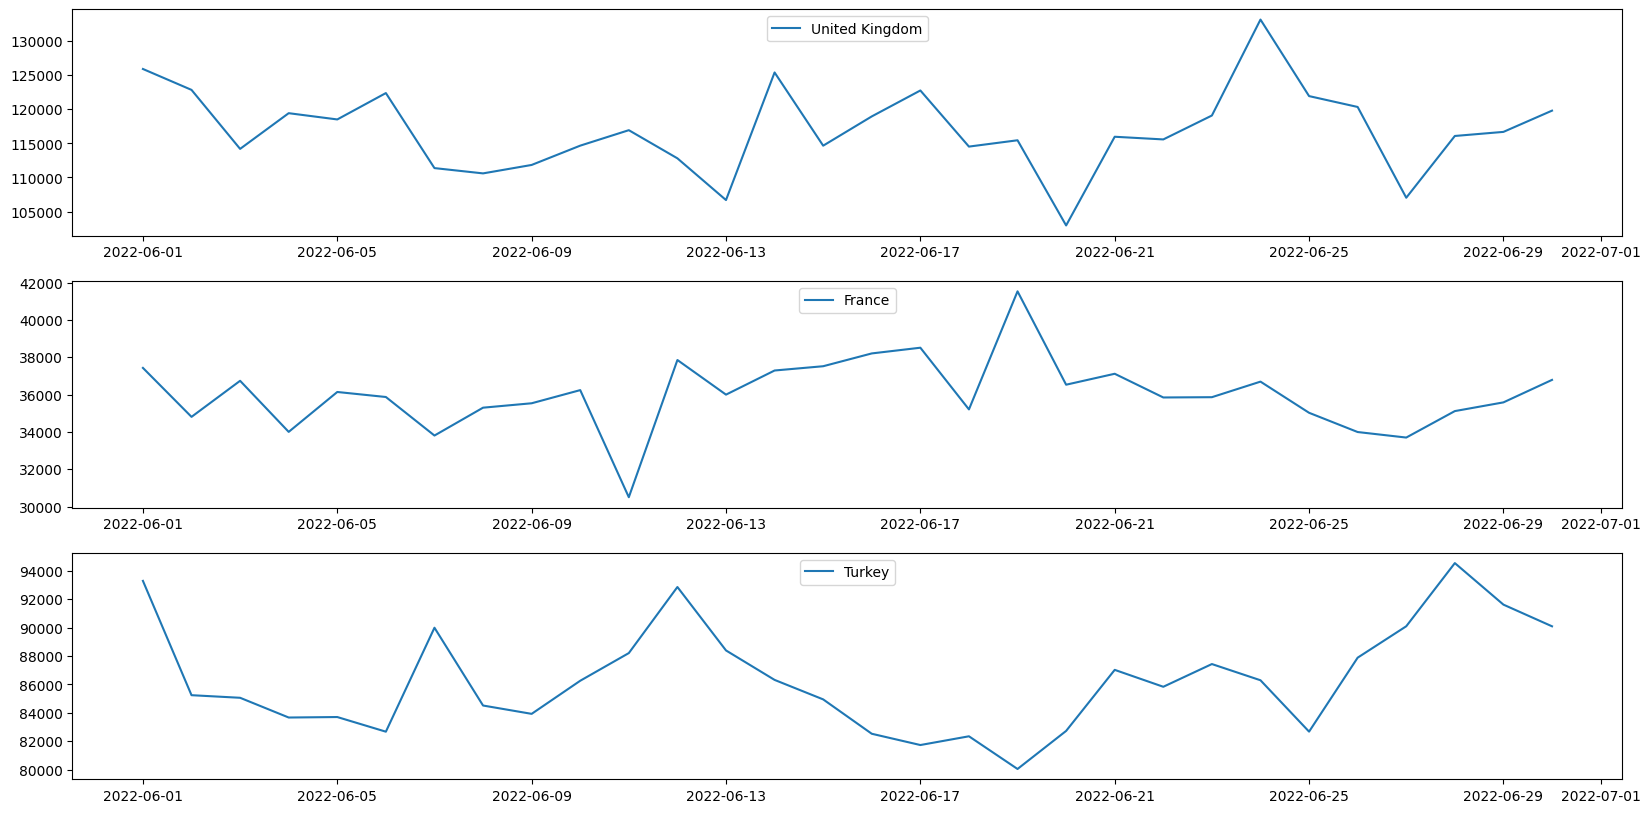

In [87]:
# Plot - Add axis labels, title
fig , axes = plt.subplots(len(country_list) , 1 , figsize = (20,10))
for _ , (ax , country) in enumerate(zip(axes , country_list)):
    df = res_country_grp[res_country_grp['en']==country][['num_twt']]
    ax.plot(df , label = country)
    ax.legend(loc = 'upper center')

In [153]:
ts_1 = res_country_grp[res_country_grp['en']==country_list[0]].num_twt.rename(country_list[0])
ts_2 = res_country_grp[res_country_grp['en']==country_list[1]].num_twt.rename(country_list[1])
ts_3 = res_country_grp[res_country_grp['en']==country_list[2]].num_twt.rename(country_list[2])

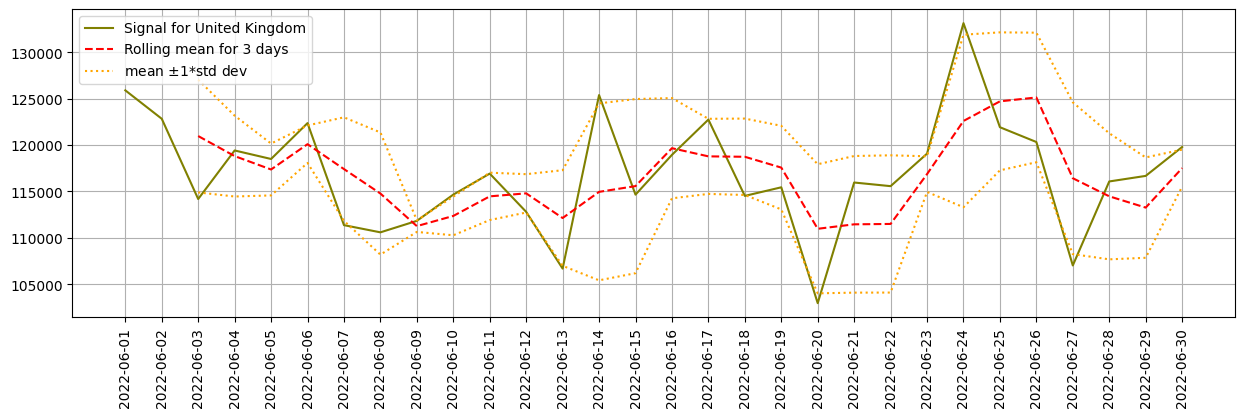

In [166]:
# Anomaly Detection using Bollinger Bands-adjacent method
fig , ax = plt.subplots(figsize = (15,4))

rate = 3
tolerance = 1
ax.plot(ts_1 , c = 'olive' , label = f'Signal for {ts_1.name}');
ax.plot(ts_1.rolling(rate).mean() , lw = 1.5 , ls = "--" , c = 'red' , label = f'Rolling mean for {rate} days');
ax.plot(ts_1.rolling(rate).mean() + tolerance*ts_1.rolling(3).std() , lw = 1.5 , ls = ":" , c = 'orange' , label = f'mean $\pm${tolerance}*std dev');
ax.plot(ts_1.rolling(rate).mean() - tolerance*ts_1.rolling(3).std() , lw = 1.5 , ls = ":" , c = 'orange');
ax.legend(loc='upper left');
ax.grid();
ax.set_xticks(ts_1.index);
ax.set_xticklabels(labels = ts_1.index, rotation = 90);

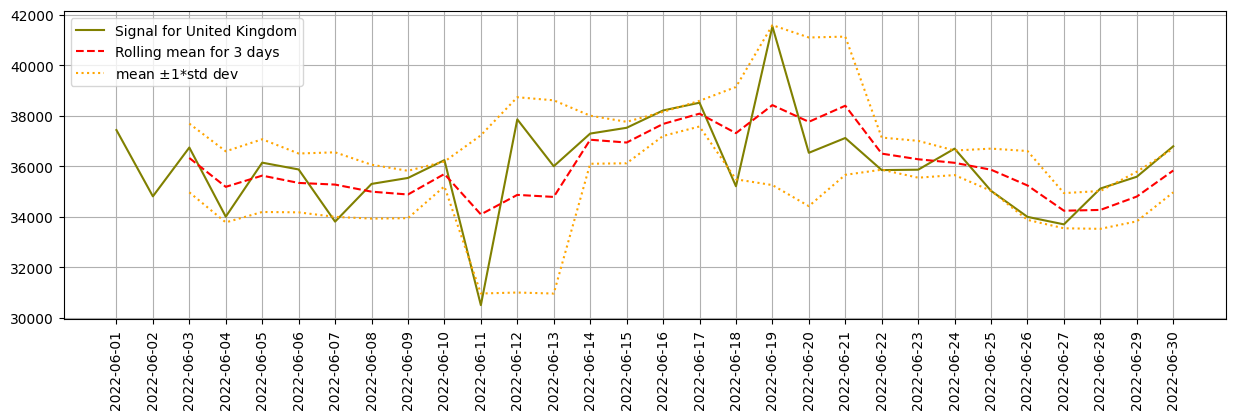

In [164]:
# Anomaly Detection using Bollinger Bands-adjacent method
fig , ax = plt.subplots(figsize = (15,4))

rate = 3
tolerance = 1
ax.plot(ts_2 , c = 'olive' , label = f'Signal for {ts_1.name}');
ax.plot(ts_2.rolling(rate).mean() , lw = 1.5 , ls = "--" , c = 'red' , label = f'Rolling mean for {rate} days');
ax.plot(ts_2.rolling(rate).mean() + tolerance*ts_2.rolling(3).std() , lw = 1.5 , ls = ":" , c = 'orange' , label = f'mean $\pm${tolerance}*std dev');
ax.plot(ts_2.rolling(rate).mean() - tolerance*ts_2.rolling(3).std() , lw = 1.5 , ls = ":" , c = 'orange');
ax.legend(loc='upper left');
ax.grid();
ax.set_xticks(ts_2.index);
ax.set_xticklabels(labels = ts_2.index, rotation = 90);

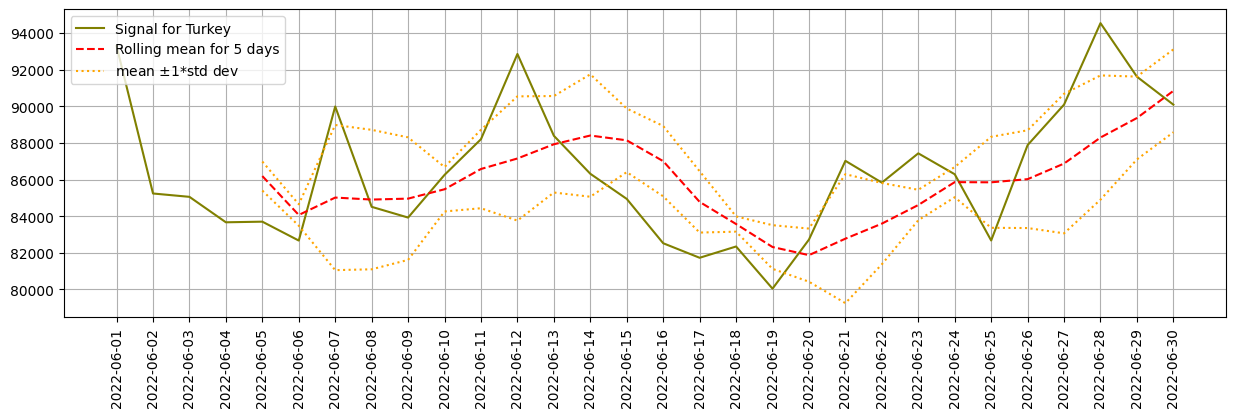

In [167]:
# Anomaly Detection using Bollinger Bands-adjacent method
fig , ax = plt.subplots(figsize = (15,4))

rate = 5
tolerance = 1
ax.plot(ts_3 , c = 'olive' , label = f'Signal for {ts_3.name}');
ax.plot(ts_3.rolling(rate).mean() , lw = 1.5 , ls = "--" , c = 'red' , label = f'Rolling mean for {rate} days');
ax.plot(ts_3.rolling(rate).mean() + tolerance*ts_3.rolling(3).std() , lw = 1.5 , ls = ":" , c = 'orange' , label = f'mean $\pm${tolerance}*std dev');
ax.plot(ts_3.rolling(rate).mean() - tolerance*ts_3.rolling(3).std() , lw = 1.5 , ls = ":" , c = 'orange');
ax.legend(loc='upper left');
ax.grid();
ax.set_xticks(ts_2.index);
ax.set_xticklabels(labels = ts_2.index, rotation = 90);

From the above graph, the following days stand out as days of 'anomalous' activity
- 24th June in the UK
- 19th June in France
- 28th June in Turkey

### **QUESTION 2**

Characterise each of these three days by <br/>
a. Making a word cloud from the tweet text. [5 marks] <br/>
b. Any other method. [5 marks]